# Problem Statement


#### 15 subject faces with happy/sad emotion are provided in the data. Each image is of 100x100 matrix.
#### Perform PCA on to reduce the dimension from 10000 to K (using PCA for high dimensional data) 
#### and then perform LDA to one dimension. Plot the one dimension features for each image. 
#### Select the optimum threshold to classify the emotion and report the classification accuracy on the test data.
#### What is the best choice of K which gives the maximum separability ?

## Libraries

In [1]:
import os
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

## Load Images

In [3]:
def load_images(folder):
    images = []
    label = []
    for filename in os.listdir(folder):
        img = mpimg.imread(os.path.join(folder, filename))
        label.append(filename.split('.')[1])
        if img is not None:
            images.append(img)
    return images,label

In [4]:
trainfolder="./emotion_classification/train"
[train_images,train_label] = load_images(trainfolder)

testfolder="./emotion_classification/test"
[test_images,test_label] = load_images(testfolder)

### Train Data

In [31]:
train_images = np.array(train_images)
train_label = np.array(train_label)

### Test Data

In [5]:
test_images = np.array(test_images)
test_label = np.array(test_label)

### Standardizing Input Matrix

In [7]:
# Calculating X(input matrix)

X = np.zeros((10201,20))
for i in range(20):
    X[:,i:i+1] = train_images[i].reshape(10201,1)
mean = np.sum(X,1)
mean = mean.reshape(10201,1)
mean = mean/20

X = X - mean

In [8]:
X.shape

(10201, 20)

## Performing PCA

In [9]:
K=15

In [11]:
def eigen(A):
    eigenValues, eigenVectors = np.linalg.eig(A)
    idx = np.argsort(eigenValues)[::-1]
    eigenValues = eigenValues[idx]
    eigenVectors = np.real(eigenVectors[:,idx])
    return (eigenValues, eigenVectors)
    

In [16]:
#Covariance Matrix S
S = np.dot(X.T,X)
S = S/20

[eig,eig_vec] = eigen(S)

eig1 = 20 * eig[:K]
eig1 = eig1 ** (-0.5)
D = np.diag(eig1)

eig_vec1 = eig_vec[:,0:K]

U = np.dot(X,eig_vec1)
U = np.dot(U,D)
    

In [17]:
#Projected Output
Y = np.dot(U.T,X)

In [18]:
Y.shape

(15, 20)

# Performing LDA on PCA output

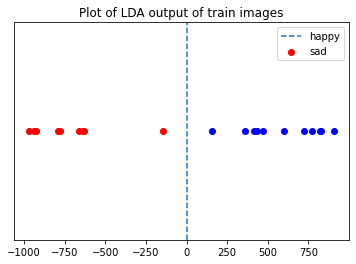

In [21]:
idx_happy = []
idx_sad = []
i=0
mean_happy = np.zeros((K,1))
mean_sad = np.zeros((K,1))
mean_lda = np.zeros((K,1))
for x in train_label:
    if x=='happy' :
        idx_happy.append(i)
        mean_happy[:,0] = mean_happy[:,0] + Y[:,i]
    elif x=='sad':
        idx_sad.append(i)
        mean_sad[:,0] = mean_sad[:,0] + Y[:,i]
    mean_lda[:,0] = mean_lda[:,0] + Y[:,i]
    i=i+1
mean_lda = mean_lda*0.05
mean_happy = mean_happy/len(idx_happy)
mean_sad = mean_sad/len(idx_sad)

mean_lda = mean_lda.reshape(K,1)
mean_happy = mean_happy.reshape(K,1)
mean_sad = mean_sad.reshape(K,1)
#################################################################
#------------Between Class Covariance----------------------------
Sb = len(idx_happy)*np.dot((mean_happy - mean_lda),(mean_happy - mean_lda).T) + len(idx_sad)*np.dot((mean_sad - mean_lda),(mean_sad - mean_lda).T)

#################################################################
#------------Within Class Covariance-----------------------------
Sw = np.zeros((K,K))
x1 = np.zeros((K,K))
x2 = np.zeros((K,K))
for idx1 in idx_happy:
    v = ((Y[:,idx1:idx1+1]).reshape(K,1))-mean_happy
    x1 = x1 + np.dot(v,v.T)

for idx2 in idx_sad:
    v = ((Y[:,idx2:idx2+1]).reshape(K,1)) - mean_sad
    x2 = x2 + np.dot(v,v.T)

Sw = x1 + x2

Sw_inv = np.linalg.inv(Sw)
eig_lda,eig_vec_lda = eigen(np.dot(Sw_inv,Sb))

w = eig_vec_lda[:,0]

fx = np.dot(w.T,Y)

fx_happy = fx[idx_happy]
fx_sad = fx[idx_sad]

plt.title("Plot of LDA output of train images")
plt.scatter(fx_happy,np.zeros_like(fx_happy),color='red')
plt.scatter(fx_sad,np.zeros_like(fx_sad),color='blue')
plt.axvline(x=0,linestyle="--")
plt.legend(["happy", "sad"])
plt.yticks([])
plt.show()

In [22]:
threshold = 0
wrong_sad_tr = len([i for i in fx_sad if i < threshold])
wrong_happy_tr = len([i for i in fx_happy if i > threshold])
Training_accuracy = ((20-wrong_sad_tr-wrong_happy_tr)/20)*100
print("Training Acccuracy in % : ",Training_accuracy)

Training Acccuracy in % :  100.0


## Testing

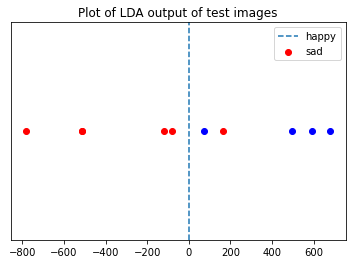

In [23]:
X_test = np.zeros((10201,10))
for i in range(10):
    X_test[:,i:i+1] = test_images[i].reshape(10201,1)
mean_te = np.sum(X_test,1)
mean_te = mean_te.reshape(10201,1)
mean_te = mean_te/10

X_test = X_test - mean_te

Y_test = np.dot(U.T,X_test)

fx_test = np.dot(w.T,Y_test)

j=0
idx_happy_te=[]
idx_sad_te=[]
for x in test_label:
    if x=='happy':
        idx_happy_te.append(j)
    elif x=='sad':
        idx_sad_te.append(j)
    j=j+1

fx_test_happy = fx_test[idx_happy_te]
fx_test_sad = fx_test[idx_sad_te]

plt.title("Plot of LDA output of test images")
plt.scatter(fx_test_happy,np.zeros_like(fx_test_happy),color='red')
plt.scatter(fx_test_sad,np.zeros_like(fx_test_sad),color='blue')
plt.axvline(x=0,linestyle="--")
plt.legend(["happy", "sad"])
plt.yticks([])
plt.show()

In [24]:
threshold = 0
wrong_sad_te = len([i for i in fx_test_sad if i < threshold])
wrong_happy_te = len([i for i in fx_test_happy if i > threshold])
Testing_accuracy = ((10-wrong_sad_te-wrong_happy_te)/10)*100
print("Testing Acccuracy in % : ",Testing_accuracy)

Testing Acccuracy in % :  90.0


In [25]:
print("Threshold = 0")
print("K = 15")

Threshold = 0
K = 15
